# **1. Import Library**

In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# **2. Memuat Dataset dari Hasil Clustering**

In [111]:
df = pd.read_csv('/content/dataset_clustering.csv')

In [112]:
df.head(5)

,Product ID,Category,Sub-Category,Sales,Profit,Quantity,Discount,Cluster
0,FUR-BO-10000112,Furniture,Bookcases,825.174,-117.8820,9,0.300000,0
1,FUR-BO-10000330,Furniture,Bookcases,1064.624,24.1960,10,0.100000,2
2,FUR-BO-10000362,Furniture,Bookcases,2154.348,311.1836,14,0.130000,2
3,FUR-BO-10000468,Furniture,Bookcases,723.842,-133.1092,21,0.183333,2
4,FUR-BO-10000711,Furniture,Bookcases,851.760,229.9752,12,0.000000,2


# **3. Data Splitting**

> Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).



In [113]:
# prepare dataset training & testing
X = df.drop('Cluster', axis=1) # drop cluster for training
y = df['Cluster'] # only cluster for testing

In [114]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(1489, 7), y_train=(1489,)
Test set shape: X_test=(373, 7), y_test=(373,)


In [115]:
# select feature
numeric_features = ['Sales', 'Profit', 'Quantity', 'Discount']
categorical_features = ['Category', 'Sub-Category']

# preprocessing data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# **4. Membangun Model Klasifikasi**


In [116]:
# Train Model
def train_model(model, X_train, y_train, preprocessor):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    return pipeline

# Evaluate Model
def evaluate_model(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'report': classification_report(y_test, y_pred)
    }

## **a. Membangun Model Klasifikasi**

<!-- Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih. -->

In [117]:
# Training Model with Random Forest & KNN (without Hyperparameter tuning)
rf_base = RandomForestClassifier(random_state=42)
knn_base = KNeighborsClassifier()

rf_pipeline_base = train_model(rf_base, X_train, y_train, preprocessor)
knn_pipeline_base = train_model(knn_base, X_train, y_train, preprocessor)

print("Finish Model training")

Finish Model training


> Disini saya membandingkan performa Random Forest dan KNN untuk proses klasifikasinya



## **b. Evaluasi Model Klasifikasi**

<!-- Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah. -->

In [118]:
# Evaluasi Model Non Hyperparameter Tuning
rf_metrics_base = evaluate_model(rf_pipeline_base, X_test, y_test)
knn_metrics_base = evaluate_model(knn_pipeline_base, X_test, y_test)

print("Random Forest Metrics:")
print(rf_metrics_base['report'])

print("\nK-Nearest Neighbors Metrics:")
print(knn_metrics_base['report'])

Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        67
           1       0.89      0.80      0.84        20
           2       1.00      0.99      0.99       286

    accuracy                           0.98       373
   macro avg       0.94      0.93      0.94       373
weighted avg       0.98      0.98      0.98       373


K-Nearest Neighbors Metrics:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        67
           1       0.94      0.80      0.86        20
           2       0.97      1.00      0.98       286

    accuracy                           0.97       373
   macro avg       0.96      0.89      0.92       373
weighted avg       0.96      0.97      0.96       373



Dari Hasil Pengujian pada data testing (model non tuning), didapatkan poin :
- Akurasi Random Forest = 0.98 vs KNN = 0.97
- Weighted Avg F1-Score Random Forest = 0.98 vs KNN = 0.96

 **Random Forest** memiliki akurasi dan weighted F1-score yang lebih tinggi daripada **KNN**, sehingga secara umum dapat dikatakan Random Forest lebih unggul untuk data ini. KNN sendiri sebenarnya performanya tidak jauh tertinggal (beda tipis) tapi jika diminta memilih model terbaik, maka **Random Forest** yang keluar sebagai pilihan utama.

## **c. Tuning Model Klasifikasi (Optional)**

In [119]:
# Training Model with Hyperaparameter tune (Random Search)
def tune_model(model, params, X_train, y_train, preprocessor):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(
        pipeline,
        params,
        n_iter=20,
        cv=3,
        scoring='f1_weighted',
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    return [search.best_estimator_, search.best_params_]

In [120]:
# Parameter for Tuning
rf_params = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__class_weight': ['balanced', None]
}

knn_params = {
    'classifier__n_neighbors': np.arange(3, 15),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

rf_tune = tune_model(RandomForestClassifier(), rf_params, X_train, y_train, preprocessor)[0]
knn_tune = tune_model(KNeighborsClassifier(), knn_params, X_train, y_train, preprocessor)[0]

print("Finish Model tuning")

Finish Model tuning


In [121]:
print(f"Best parameters Random Forest (Random Search): {rf_tune[1]}")
print(f"Best parameters KNN (Random Search): {knn_tune[1]}")

Best parameters Random Forest (Random Search): RandomForestClassifier(class_weight='balanced', min_samples_split=5)
Best parameters KNN (Random Search): KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

<!-- Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa. -->

In [122]:
rf_metrics_tuned = evaluate_model(rf_tune, X_test, y_test)
knn_metrics_tuned = evaluate_model(knn_tune, X_test, y_test)

print("Random Forest Metrics (Tuned):")
print(rf_metrics_tuned['report'])

print("\nK-Nearest Neighbors Metrics (Tuned):")
print(knn_metrics_tuned['report'])

Random Forest Metrics (Tuned):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        67
           1       0.83      0.95      0.88        20
           2       0.99      0.98      0.99       286

    accuracy                           0.98       373
   macro avg       0.93      0.97      0.95       373
weighted avg       0.98      0.98      0.98       373


K-Nearest Neighbors Metrics (Tuned):
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        67
           1       0.88      0.75      0.81        20
           2       0.96      0.99      0.97       286

    accuracy                           0.95       373
   macro avg       0.93      0.86      0.89       373
weighted avg       0.95      0.95      0.95       373



Dari Hasil Pengujian pada data testing (model tuning), didapatkan poin :

- Akurasi Random Forest = 0.98 vs KNN = 0.95

- Weighted Avg F1-Score Random Forest = 0.98 vs KNN = 0.95

Sama dengan model tanpa tuning, Random Forest mendapatkan nilai akurasi yang lebih baik dari pada KNN pada dataset ini. mungkin agak aneh, namun menariknya hyperparameter tuning yang dilakukan untuk algoritma Random Forest tidak berdampak pada hasil metriks evaluasinya, namun untuk KNN cukup berdampak, bahkan menurunkan hasil evaluasi metriks akurasi dan avg F1 scorenya.

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

In [123]:
results = pd.DataFrame({
    'Model': ['Random Forest (Base)', 'Random Forest (Tuned)', 'KNN (Base)', 'KNN (Tuned)'],
    'Accuracy': [
        rf_metrics_base['accuracy'],
        rf_metrics_tuned['accuracy'],
        knn_metrics_base['accuracy'],
        knn_metrics_tuned['accuracy']
    ],
    'Precision': [
        rf_metrics_base['precision'],
        rf_metrics_tuned['precision'],
        knn_metrics_base['precision'],
        knn_metrics_tuned['precision']
    ],
    'Recall': [
        rf_metrics_base['recall'],
        rf_metrics_tuned['recall'],
        knn_metrics_base['recall'],
        knn_metrics_tuned['recall']
    ],
    'F1-Score': [
        rf_metrics_base['f1'],
        rf_metrics_tuned['f1'],
        knn_metrics_base['f1'],
        knn_metrics_tuned['f1']
    ]
})

print("Metriks Perbandingan : \n")
print(results.round(4))

Metriks Perbandingan : 

                   Model  Accuracy  Precision  Recall  F1-Score
0   Random Forest (Base)    0.9812     0.9812  0.9812    0.9809
1  Random Forest (Tuned)    0.9812     0.9826  0.9812    0.9817
2             KNN (Base)    0.9651     0.9650  0.9651    0.9642
3            KNN (Tuned)    0.9517     0.9510  0.9517    0.9502


<Figure size 1000x600 with 0 Axes>

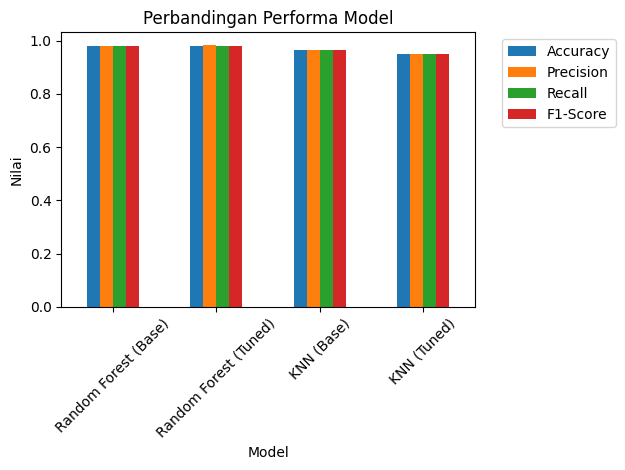

In [124]:
plt.figure(figsize=(10, 6))
results.set_index('Model').plot(kind='bar', rot=45)
plt.title('Perbandingan Performa Model')
plt.ylabel('Nilai')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [125]:
# Check Model is Overfitting or Not
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score

rf_train_score_untuned, rf_test_score_untuned = check_overfitting(rf_pipeline_base, X_train, y_train, X_test, y_test)
knn_train_score_untuned, knn_test_score_untuned = check_overfitting(knn_pipeline_base, X_train, y_train, X_test, y_test)

rf_train_score_tuned, rf_test_score_tuned = check_overfitting(rf_tune, X_train, y_train, X_test, y_test)
knn_train_score_tuned, knn_test_score_tuned = check_overfitting(knn_tune, X_train, y_train, X_test, y_test)

df_scores = pd.DataFrame({
    'Model': ['Random Forest (Base)', 'Random Forest (Tuned)', 'KNN (Base)', 'KNN (Tuned)'],
    'Train Score': [rf_train_score_untuned, rf_train_score_tuned, knn_train_score_untuned, knn_train_score_tuned],
    'Test Score': [rf_test_score_untuned, rf_test_score_tuned, knn_test_score_untuned, knn_test_score_tuned]
})

df_scores

,Model,Train Score,Test Score
0,Random Forest (Base),1.000000,0.981233
1,Random Forest (Tuned),0.996642,0.981233
2,KNN (Base),0.969107,0.965147
3,KNN (Tuned),1.000000,0.951743


Kesimpulan:

1. Random Forest vs KNN

  - Random Forest (baik versi base maupun tuned) secara konsisten unggul dibanding KNN (base maupun tuned) di semua metrik (Accuracy, Precision, Recall, dan F1-Score).
  - Hal ini menunjukkan bahwa untuk dataset dan skenario ini, algoritma Random Forest lebih efektif daripada algortima KNN.

2. Perbandingan Random Forest (Base) vs Random Forest (Tuned)

  - Kedua versi Random Forest memiliki Accuracy yang sama (0.9812).
  - Namun, Random Forest (Tuned) sedikit lebih baik dalam Precision (0.9826 vs 0.9812) dan juga F1-Score (0.9817 vs 0.9809).
  - Perbedaan ini tergolong kecil, tetapi tetap menunjukkan bahwa tuning hyperparameter mampu memberikan peningkatan performa walau tipis.

3. Perbandingan KNN (Base) vs KNN (Tuned)

  - KNN (Base) memiliki Accuracy sebesar 0.9651, sedangkan KNN (Tuned) justru turun menjadi 0.9517.
  - Demikian pula pada metrik Precision, Recall, dan F1-Score, versi tuned lebih rendah.
  - Ini mengindikasikan bahwa proses tuning pada KNN belum optimal atau parameter yang di set saat ini tidak sesuai sehingga menurunkan performa model.

4. Apakah Model Underfitting & Overfitting?
  - Underfitting tidak terjadi pada model model yang dihasilkan karena hasil uji evaluasi pada data training tinggi.
  - Overfitting terindikasi sedikit pada model Random Forest (Base & Tuned) namun tidak signifikan, model KNN (base) menunjukan generalisasi yang baik dengan gap yang sangat kecil, berbanding terbalik dengan model KNN (tune) yang menunjukan overfitting yang lebih jelas karena gap antara nilai evaluasi training dan testing yang cukup besar.
  
Model Terbaik Secara keseluruhan, Random Forest (Tuned) menjadi model terbaik karena memiliki nilai precision dan F1-score yang sedikit lebih unggul, dengan accuracy yang tetap tinggi.

In [126]:
# Save Model KNN & Random Forest
import joblib

joblib.dump(rf_pipeline_base, 'rf_pipeline_base.pkl')
joblib.dump(knn_pipeline_base, 'knn_pipeline_base.pkl')
joblib.dump(rf_tune, 'rf_tune.pkl')
joblib.dump(knn_tune, 'knn_tune.pkl')

['knn_tune.pkl']